### Brain Tumor classification using Resnet 50

In [1]:
    pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np 
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers


## Sample Images

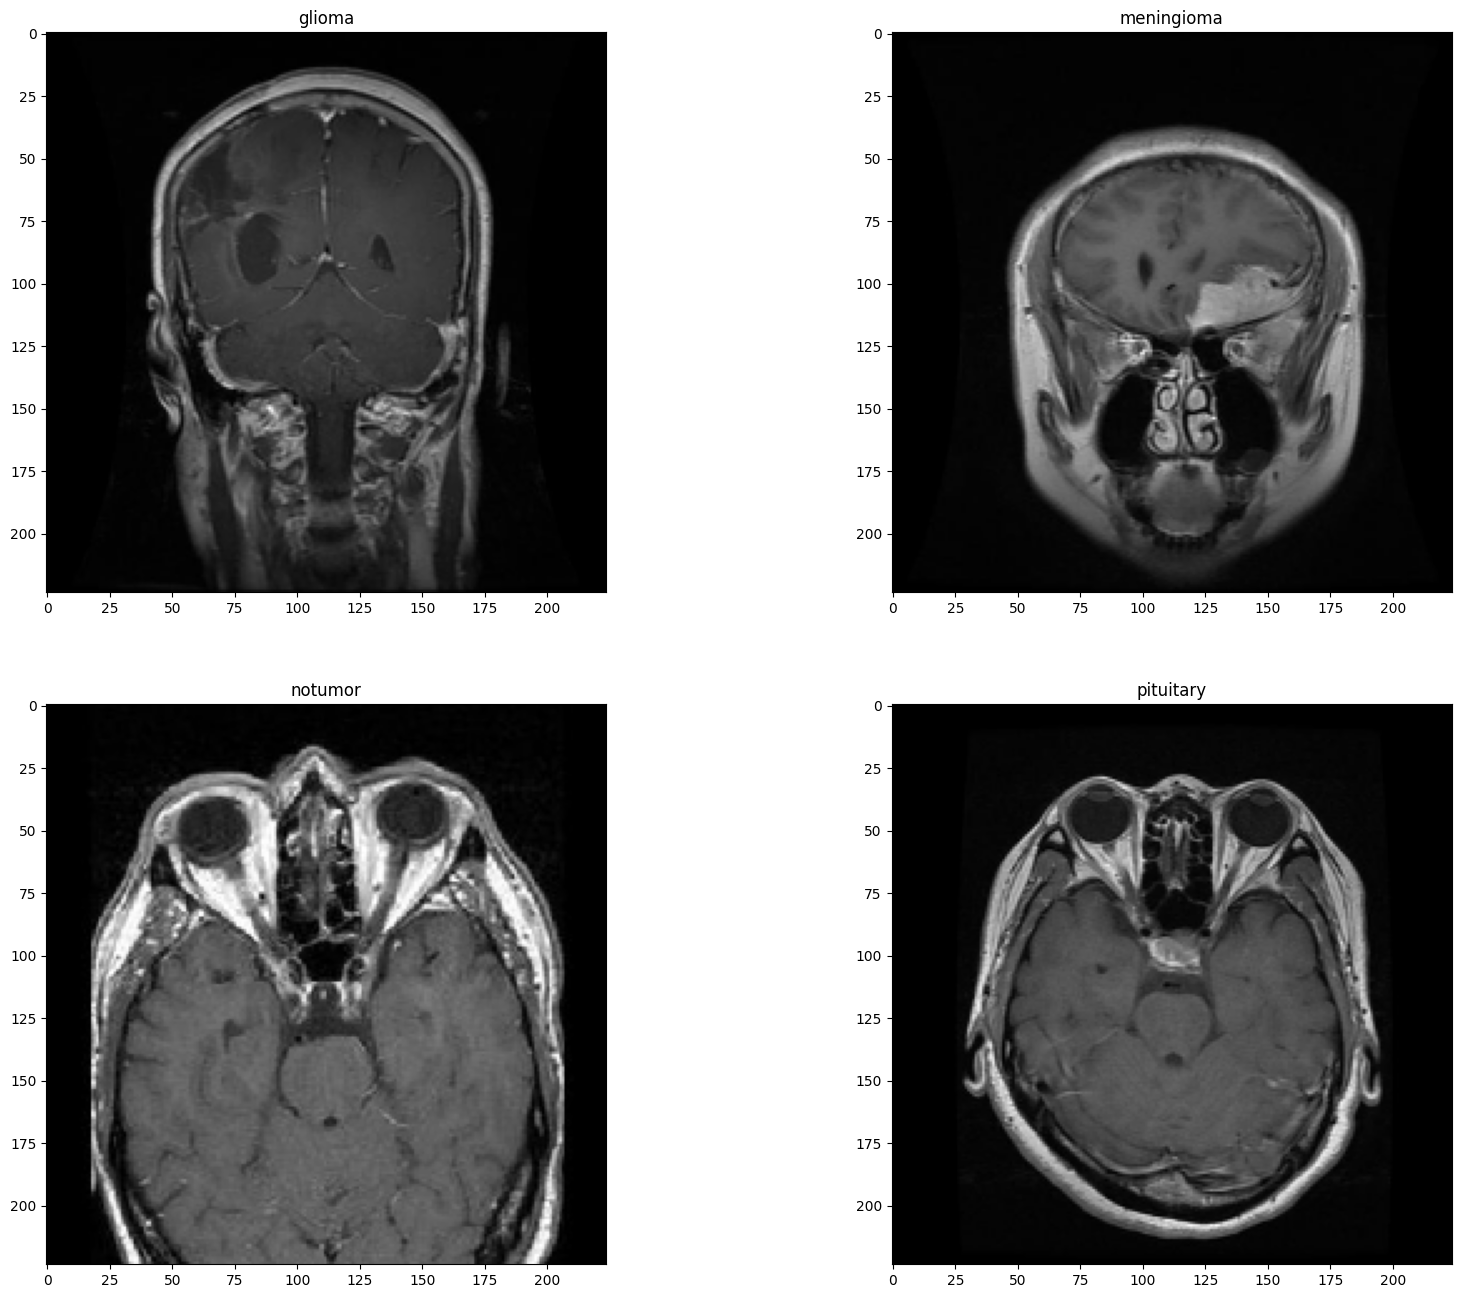

In [4]:
data_dir = ('Training')#load training folder 
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-gl_0010.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(categories[i])

## Cropping Images 

In [5]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

In [6]:
img = cv2.imread('Training/meningioma/Tr-meTr_0000.jpg')#import image
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

## Steps for Cropping

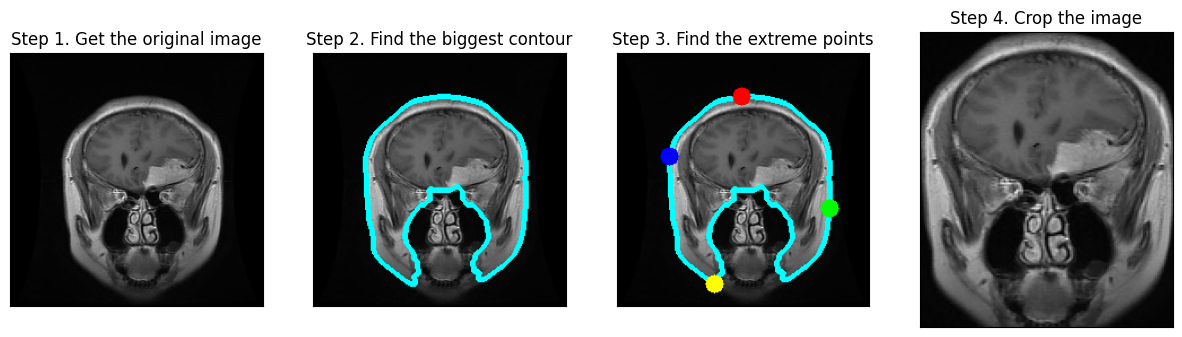

In [7]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [8]:
if __name__ == "__main__":
	training = "Training" # load training folder
	testing = "Testing" # load testing folder
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'cropped/Training/'+ dir #make a cropped folder for all the cropped images
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'cropped/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

## Loading images in cropped folder according to subnames given

In [10]:
#Run the below code twice for correctly loading the images

In [11]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('cropped/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('cropped/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:01<00:00, 239.76it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


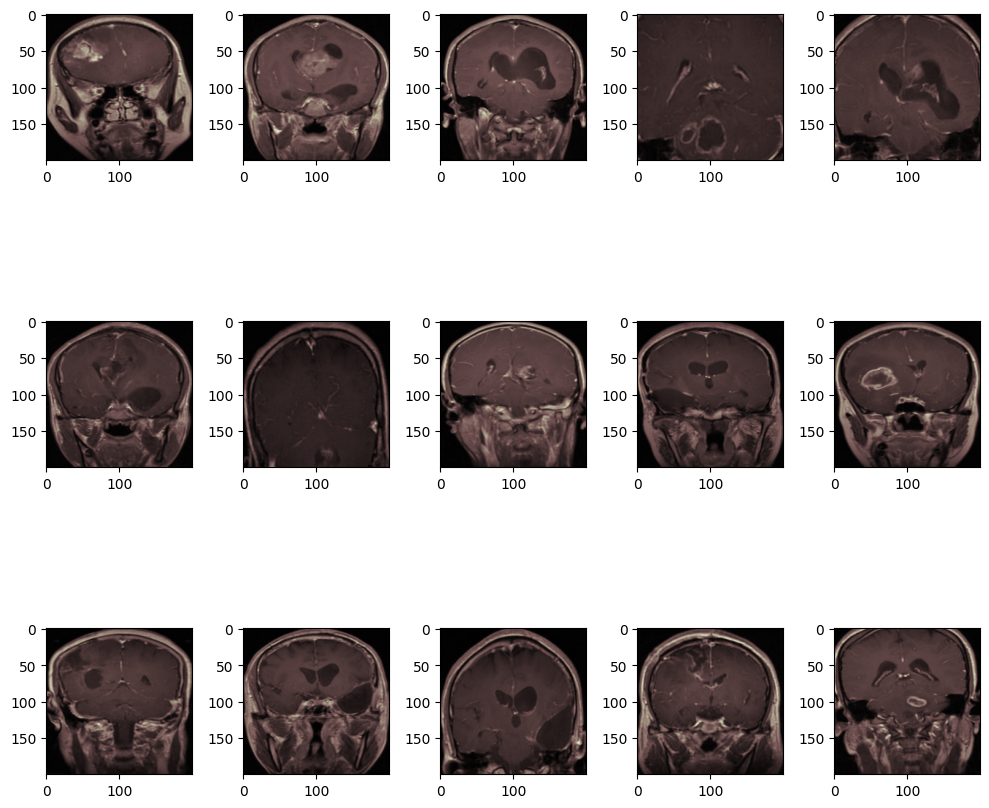

In [12]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

## Splitting the data into training and validation sets


In [13]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tensorflow.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


In [14]:
print("Training set:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("Number of samples in training set:", len(x_train))

print("\nValidation set:")
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("Number of samples in validation set:", len(x_val))


Training set:
x_train shape: (4569, 200, 200, 3)
y_train shape: (4569, 4)
Number of samples in training set: 4569

Validation set:
x_val shape: (1143, 200, 200, 3)
y_val shape: (1143, 4)
Number of samples in validation set: 1143


## Pre method for checking if the images in x_train array are non empty or not suitable of the operation

In [15]:
empty_images = []
non_suitable_images = []

# Iterate through the images in x_train
for i, image in enumerate(x_train):
    # Check if the image is empty (all pixels are zero)
    if np.any(image != 0):
        # Check if the image is non-suitable based on certain criteria
        # Replace the condition below with your own criteria for non-suitability
        if image.shape != (200, 200, 3):
            non_suitable_images.append(i)
    else:
        empty_images.append(i)

# Print the indices of empty and non-suitable images
print("Empty Images:", empty_images)
print("Non-suitable Images:", non_suitable_images)


Empty Images: []
Non-suitable Images: []


## Image Augmentation

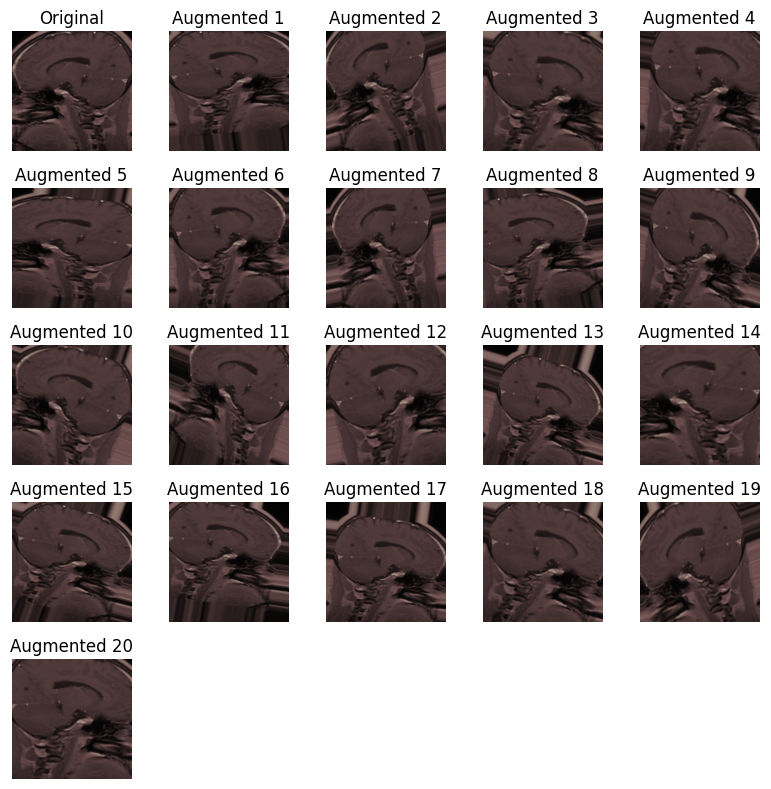

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming x_train is a numpy array containing the training images

# Create the "augmented" folder if it doesn't exist
if not os.path.exists("augmented"):
    os.makedirs("augmented")

# Reshape the original image to match the input shape expected by the generator
original_image = x_train[0]
original_image = np.expand_dims(original_image, axis=0)

# Create an instance of the ImageDataGenerator for augmented images
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate the image randomly between -20 to +20 degrees
    width_shift_range=0.1,  # Shift the image horizontally by a random fraction (up to 10%)
    height_shift_range=0.1,  # Shift the image vertically by a random fraction (up to 10%)
    shear_range=0.2,  # Shear the image randomly with a maximum shear intensity of 0.2
    zoom_range=0.2,  # Zoom into the image by up to 20%
    horizontal_flip=True,  # Flip the image horizontally
    fill_mode='nearest'  # Fill in any newly created pixels after rotation or shifting
)

# Generate augmented images
augmented_images = []
for i in range(20):
    augmented_image = datagen.flow(original_image, batch_size=1)[0][0]
    augmented_images.append(augmented_image)

    # Save the augmented image to the "augmented" folder
    filename = f"augmented/augmented_{i}.png"
    plt.imsave(filename, augmented_image)

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(5, 5, 1)
plt.imshow(original_image[0])
plt.title('Original')
plt.axis('off')

# Display augmented images
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(5, 5, i + 2)
    plt.imshow(augmented_image)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)


datagen.fit(x_train)

## Fine tuning the model on a specific dataset

In [18]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

In [19]:
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [36]:
callbacks = [ModelCheckpoint('MYMODEL.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [37]:
train_len = len(x_train)
val_len = len(x_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
4569
-----------Validation Data length-----------------
1143


## Model Training with Data Augmentation and Callbacks

In [22]:
#SKIP THE STEP BELOW AS IT WOULD TAKE ALMOST 3 HOURS TO COMPLETE


# SKIP THE BELOW STEP

In [92]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),validation_data = (x_val,y_val),epochs = 15,callbacks = callbacks)
# It is used to make a perfect resnet model 

Epoch 1/15
72/72 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9842 
Epoch 1: val_loss did not improve from 1.97291
72/72 [==============================] - 961s 13s/step - loss: 0.0464 - accuracy: 0.9842 - val_loss: 3.1656 - val_accuracy: 0.2266 - lr: 1.0000e-04
Epoch 2/15
72/72 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9880 
Epoch 2: val_loss did not improve from 1.97291
72/72 [==============================] - 894s 12s/step - loss: 0.0385 - accuracy: 0.9880 - val_loss: 2.6012 - val_accuracy: 0.2196 - lr: 1.0000e-04
Epoch 3/15
72/72 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9941 
Epoch 3: val_loss did not improve from 1.97291
72/72 [==============================] - 912s 13s/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 3.7633 - val_accuracy: 0.2108 - lr: 1.0000e-04
Epoch 4/15
72/72 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9923 
Epoch 4: val_loss did not improve f

## Learning Curves

Downlaod the model and it put it in the same folder

MODEL LINK->

In [ ]:
# I HAVE ALREADY CALCULATED THE LOSS AND ACCURACY FOR 15 epochs 

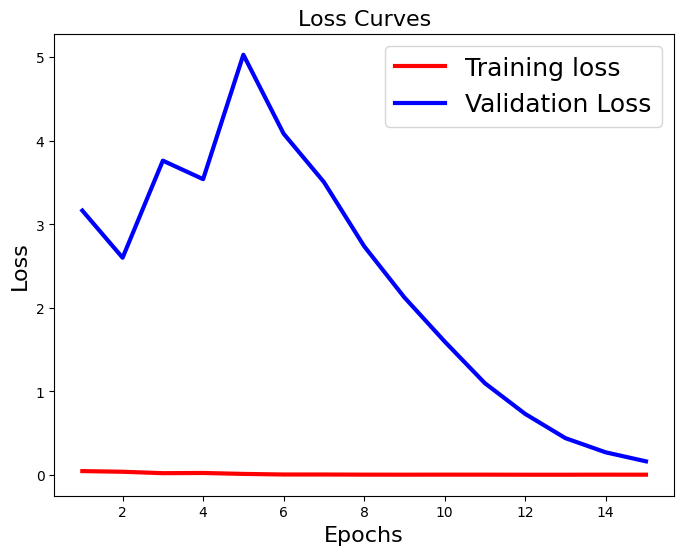

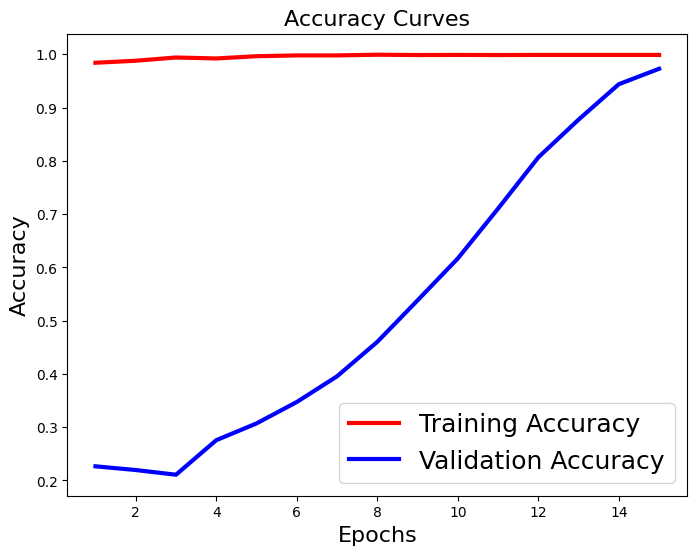

In [38]:
import matplotlib.pyplot as plt

epochs = range(1, 16)  # Assuming you have trained the model for 15 epochs

# Loss Curves
plt.figure(figsize=[8, 6])
plt.plot(epochs, [0.0464, 0.0385, 0.0215, 0.0239, 0.0127, 0.0057, 0.0055, 0.0039, 0.0034, 0.0039, 0.0037, 0.0030, 0.0030, 0.0036, 0.0034], 'r', linewidth=3.0)
plt.plot(epochs, [3.1656, 2.6012, 3.7633, 3.5417, 5.0316, 4.0860, 3.5073, 2.7386, 2.1256, 1.5974, 1.0983, 0.7310, 0.4407, 0.2710, 0.1633], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

# Accuracy Curves
plt.figure(figsize=[8, 6])
plt.plot(epochs, [0.9842, 0.9880, 0.9941, 0.9923, 0.9965, 0.9980, 0.9980, 0.9993, 0.9987, 0.9989, 0.9987, 0.9989, 0.9989, 0.9989, 0.9989], 'r', linewidth=3.0)
plt.plot(epochs, [0.2266, 0.2196, 0.2108, 0.2756, 0.3071, 0.3473, 0.3955, 0.4602, 0.5381, 0.6168, 0.7104, 0.8066, 0.8775, 0.9440, 0.9729], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()


# SKIP THIS STEP AS IT PLOTS FOR ALL THE EPOCHS YOU WANT TO SEE OUTPUT TO

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

## Loading Model

In [39]:
from tensorflow.keras.models import load_model
model = load_model('MY_MODEL.hdf5')# load the model
model.save('New model/mymodel.h5')#saving the model in My model folder in Brain tumor web app
#NOTE - You have to create the folder in the webapp folder where it will be created into .h5 file type which is the resnet model
model = load_model('New model/mymodel.h5')# loading the model created into to the model frame

c:\Users\91977\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Validation on Test set

In [40]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 64s 1s/step - loss: 0.1461 - accuracy: 0.9733


In [144]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

41/41 [==============================] - 55s 1s/step
              precision    recall  f1-score   support

      glioma       0.92      0.99      0.95       300
  meningioma       0.99      0.93      0.96       306
    no_tumor       0.99      0.99      0.99       405
   pituitary       1.00      0.97      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



## Confusion Matrix

164/164 [==============================] - 77s 468ms/step


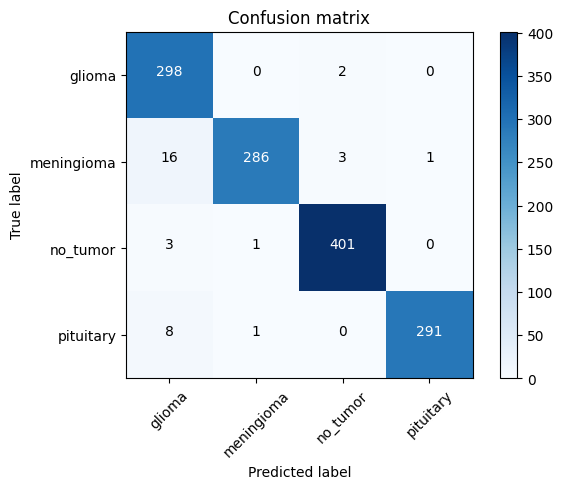

In [100]:
import itertools
pred_Y = model.predict(x_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

82/82 [==============================] - 69s 845ms/step


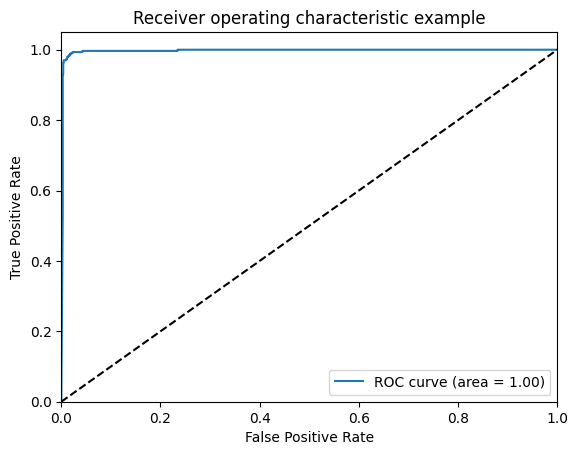

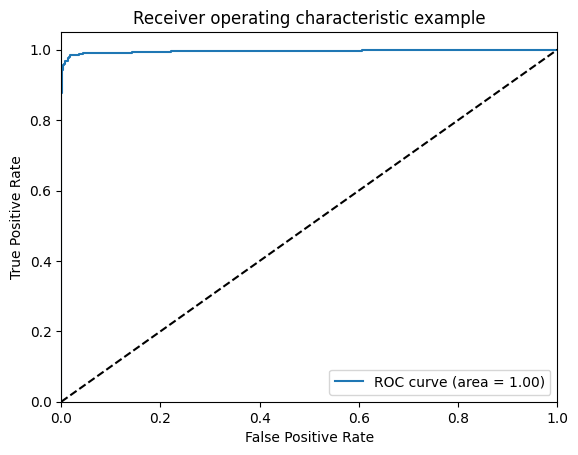

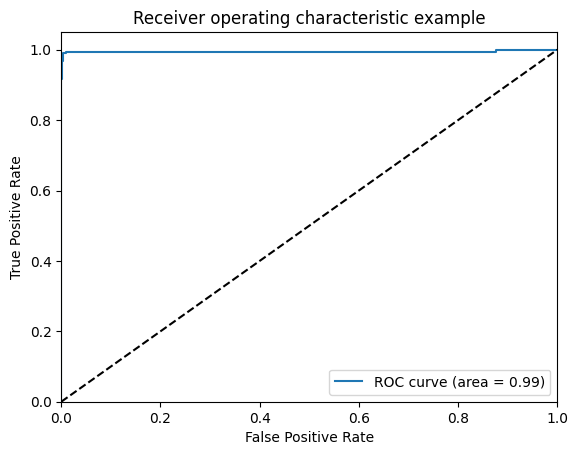

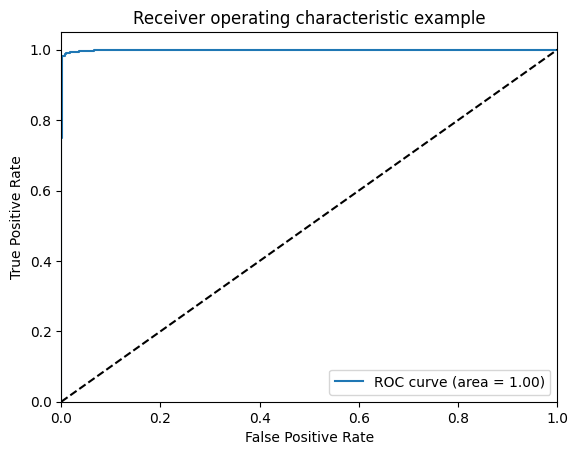

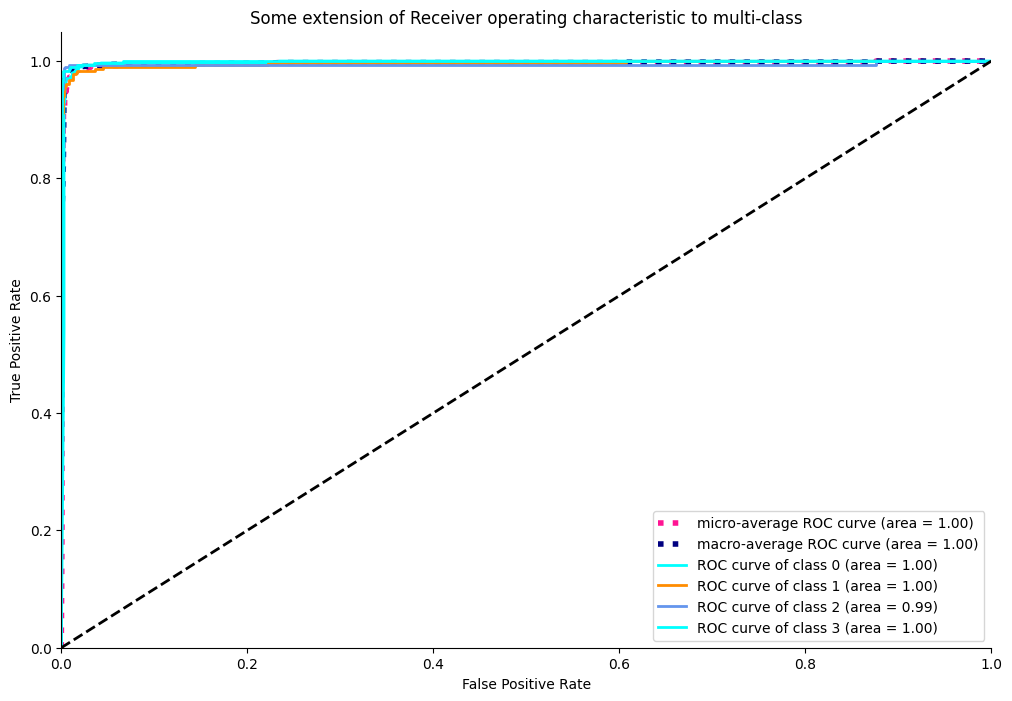

In [101]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_test = np.array(y_test)

n_classes = 4

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

## Plotting sample predictions

41/41 [==============================] - 60s 1s/step


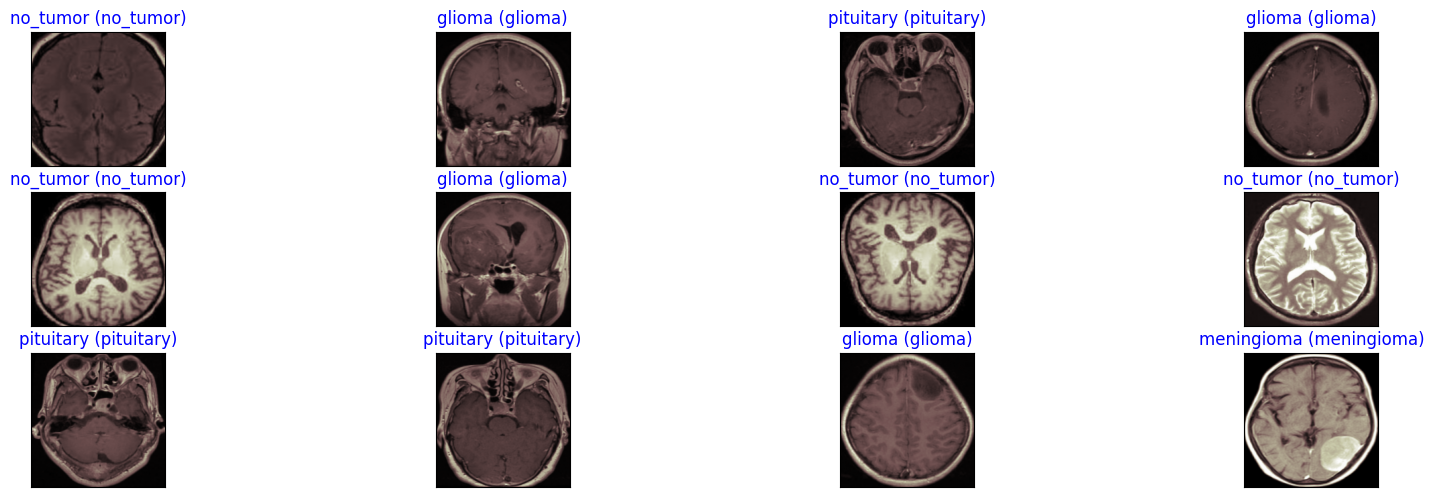

In [102]:
y_hat = model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))